In [306]:
import pickle
import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns 

CURRENT_MODEL = None
N_dim = 100


x1_min = -10
x1_max = 10

x2_min = 20
x2_max = 40

test_min = -1
test_max= 1

limits = [x1_min, x1_max, x2_min, x2_max]
test_limits = [test_min, test_max]

num_samples = 50

In [2]:
import torch

In [3]:
with open('../data_size_experiment_5_repeats.p','rb') as F:
    all_info = pickle.load(F)

In [4]:
def predict(model, sample):
    return torch.argmax(model(sample),1)

def pred_prob(model, sample, category_num):
    return torch.softmax(model(sample), 1)[:,category_num]

### Confirm that in_dist_advs fail

In [5]:
failed_model = all_info[0][0][500000]
good_samples = torch.vstack(all_info[0][1][500000].starts)

In [6]:
# all_info

In [7]:
failed_samples = torch.from_numpy(np.vstack(all_info[0][1][500000].in_dist_advs)).float()

In [8]:
good_predictions = predict(failed_model, good_samples)

In [9]:
failed_predictions = predict(failed_model, failed_samples)

In [10]:
print(good_predictions.tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
print(failed_predictions.tolist())

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


#### As expected results

# Perturbation in Random Directions

In [400]:
def perturb_and_torchify(sample, low , high):
    rand_pert_matrix = torch.vstack([(high-low)*torch.rand(sample.shape[1]) + low for i in range(sample.shape[0])])
    ones_matrix = torch.ones((rand_pert_matrix.shape))
    mult_mat = ones_matrix + rand_pert_matrix
    jittered_sample = torch.multiply(sample, mult_mat)
    return jittered_sample

#### Perturbing good samples

In [401]:
failed_fractions = {}
for pert in np.arange(0.5,5.5,0.5):
    failed = 0
    for i in range(20):
        perturbed_input = perturb_and_torchify(good_samples,-pert,pert)
        out_list = predict(failed_model, perturbed_input).tolist()
        zeros = torch.sum(torch.tensor(out_list)==0).item()
        ones = torch.sum(torch.tensor(out_list)==1).item()
        pred = int(ones >= zeros)
        failed += pred
    failed_fractions["%.02f"%pert] = (failed/20)

In [402]:
failed_fractions.keys()

dict_keys(['0.50', '1.00', '1.50', '2.00', '2.50', '3.00', '3.50', '4.00', '4.50', '5.00'])

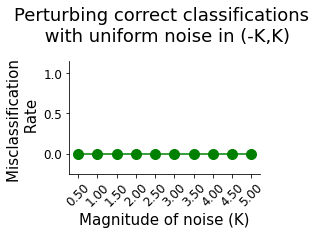

In [403]:
plt.figure(figsize=(4,3.5))
plt.plot(range(len(failed_fractions.values())), failed_fractions.values(), marker='o',color='green', markersize=10)
plt.ylim(-0.25,1.15)
plt.xlabel('Magnitude of noise (K)', fontsize=15)
plt.ylabel('Misclassification \n Rate', fontsize=15)

plt.xticks(ticks = range(len(failed_fractions.values())), labels = failed_fractions.keys(), rotation=45, fontsize=12)
plt.yticks(fontsize=12)
sns.despine()

plt.title('Perturbing correct classifications \n with uniform noise in (-K,K)',fontsize=18, y=1.12)
plt.tight_layout()
plt.savefig('paper_figures/perturb_good_random.pdf', bbox_inches='tight')
plt.show()

In [58]:
# plt.plot(failed_fractions.values(), marker='o', color='black')
# plt.title('Perturbing correct classifications \n with uniform noise in (-K,K)')
# plt.xticks(range(len(failed_fractions)), labels = failed_fractions.keys())
# plt.xlabel('Magnitude of noise (K)')
# plt.ylabel('Misclassification Rate')
# plt.show()

#### perturbing bad samples

In [59]:
recovery_fractions = {}
for pert in np.arange(0.5,5.5,0.5):
    failed = 0
    for i in range(20):
        perturbed_input = perturb_and_torchify(failed_samples,-pert,pert)
        out_list = predict(failed_model, perturbed_input).tolist()
        zeros = torch.sum(torch.tensor(out_list)==0).item()
        ones = torch.sum(torch.tensor(out_list)==1).item()
        pred = int(ones >= zeros)
        failed += pred
    recovery_fractions["%.02f"%pert] = (failed/20)

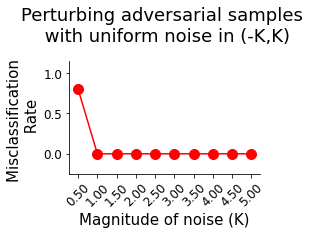

In [60]:
plt.figure(figsize=(4,3.5))
plt.plot(range(len(recovery_fractions.values())), recovery_fractions.values(), marker='o',color='red', markersize=10)
plt.ylim(-0.25,1.15)
plt.xlabel('Magnitude of noise (K)', fontsize=15)
plt.ylabel('Misclassification \n Rate', fontsize=15)

plt.xticks(ticks = range(len(recovery_fractions.values())), labels = recovery_fractions.keys(), rotation=45, fontsize=12)
plt.yticks(fontsize=12)
sns.despine()

plt.title('Perturbing adversarial samples \n with uniform noise in (-K,K)',fontsize=18, y=1.12)
plt.tight_layout()
plt.savefig('paper_figures/perturb_bad_random.pdf', bbox_inches='tight')
plt.show()

In [36]:
# plt.plot(recovery_fractions.values(), marker='o', color='black')
# plt.title('Adversarial samples recovery rate by perturbing \n with uniform noise from range -K,K')
# plt.xticks(range(len(recovery_fractions)), labels = recovery_fractions.keys())
# plt.xlabel('Magnitude of uniform noise (K)')
# plt.ylabel('% Recovery Rate')
# plt.show()

# Adversarial Direction

In [292]:
adversarial_vectors = failed_samples - good_samples

#### Good samples

In [293]:
failed_fractions = {}
for pert in np.arange(-1.0,2.25,0.25):
    failed = 0
    for i in range(20):
        perturbed_input = good_samples + pert * adversarial_vectors
        out_list = predict(failed_model, perturbed_input).tolist()
        zeros = torch.sum(torch.tensor(out_list)==0).item()
        ones = torch.sum(torch.tensor(out_list)==1).item()
        pred = int(ones >= zeros)
        failed += pred
    failed_fractions["%.02f"%pert] = (failed/20)

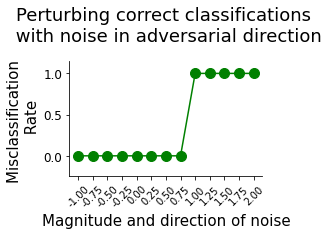

In [303]:
plt.figure(figsize=(4,3.5))
plt.plot(range(len(failed_fractions.values())), failed_fractions.values(), marker='o',color='green', markersize=10)
plt.ylim(-0.25,1.15)
plt.xlabel('Magnitude and direction of noise', fontsize=15)
plt.ylabel('Misclassification \n Rate', fontsize=15)

plt.xticks(ticks = range(len(failed_fractions.values())), labels = failed_fractions.keys(), rotation=45, fontsize=10)
plt.yticks(fontsize=12)
sns.despine()

plt.title('Perturbing correct classifications \n with noise in adversarial direction',fontsize=18, y=1.12)
plt.tight_layout()
plt.savefig('paper_figures/perturb_good_adv.pdf', bbox_inches='tight')
plt.show()

In [304]:
# plt.plot(failed_fractions.values(), marker='o', color='black')
# plt.title('Good samples failure rate with \n adversarial noise found using CMA')
# plt.xticks(range(len(failed_fractions)), labels = failed_fractions.keys())
# plt.xlabel('Magnitude of adversarial noise added (K)')
# plt.ylabel('% Failure Rate')
# plt.show()

#### Bad samples

In [301]:
recovery_fractions = {}
for pert in np.arange(-1.5,2.25,0.25):
    failed = 0
    for i in range(20):
        perturbed_input = failed_samples + pert * adversarial_vectors
        out_list = predict(failed_model, perturbed_input).tolist()
        zeros = torch.sum(torch.tensor(out_list)==0).item()
        ones = torch.sum(torch.tensor(out_list)==1).item()
        pred = int(ones >= zeros)
        failed += pred
    recovery_fractions["%.02f"%pert] = (1 - failed/20)

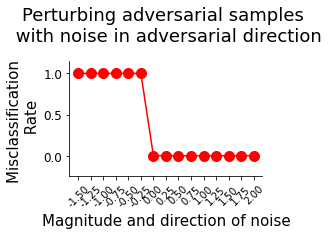

In [305]:
plt.figure(figsize=(4,3.5))
plt.plot(range(len(recovery_fractions.values())), recovery_fractions.values(), marker='o',color='red', markersize=10)
plt.ylim(-0.25,1.15)
plt.xlabel('Magnitude and direction of noise', fontsize=15)
plt.ylabel('Misclassification \n Rate', fontsize=15)

plt.xticks(ticks = range(len(recovery_fractions.values())), labels = recovery_fractions.keys(), rotation=45, fontsize=10)
plt.yticks(fontsize=12)
sns.despine()

plt.title('Perturbing adversarial samples \n with noise in adversarial direction',fontsize=18, y=1.12)
plt.tight_layout()
plt.savefig('paper_figures/perturb_bad_adv.pdf', bbox_inches='tight')
plt.show()

In [66]:
# plt.figure(figsize=(15,5))
# plt.plot(recovery_fractions.values(), marker='o', color='black')
# plt.title('Adversarial samples corrected by pooling over \n adversarial noise found using CMA')
# plt.xticks(range(len(recovery_fractions)), labels = recovery_fractions.keys())
# plt.xlabel('Magnitude of adversarial noise (K)')
# plt.ylabel('% adversarial samples corrected')
# plt.show()

#### It takes a lot of adv directions to break good samples, but very little of it to correct bad ones.

# Adversarial + Orthogonal Directions

In [260]:
sns

<module 'seaborn' from '/om5/user/smadan/miniconda3/envs/diff_rendering_ml/lib/python3.8/site-packages/seaborn/__init__.py'>

In [404]:
def perpendicular_vector(vt):
    v = np.array(vt)
    random_vector = np.random.randn(N_dim)
    orthogonal = random_vector - random_vector.dot(v)*v/np.linalg.norm(v)**2
    orthogonal_normalized = orthogonal/np.linalg.norm(orthogonal) * np.linalg.norm(v)
    return torch.from_numpy(orthogonal_normalized)

def plot_church_window(model, start_point, adv_point, plot_title, save_name=False):
    adv_vector = adv_point - start_point
    orthogonal_vector = perpendicular_vector(adv_vector)


    ##### Collect Predictions ######
    predictions = np.zeros((40,40))

    row_num = 0
    col_num = 0

    for alpha in np.arange(0.2, 5.2, 0.125):
        for beta in np.arange(0.2, 5.2, 0.125):
            curr_point = start_point + beta*adv_vector + alpha*orthogonal_vector
            if torch.max(curr_point)>10:
                curr_pred = 2 + predict(model, curr_point.unsqueeze(0).float())
            else:
                curr_pred = predict(model, curr_point.unsqueeze(0).float())
            predictions[row_num][col_num] = curr_pred
            col_num += 1
        row_num += 1
        col_num = 0
#     return predictions
    ##### Plot ######
    sns.despine()
    plt.figure(figsize=(4,3.5))
    custom_cmap = colors.ListedColormap(['white','red','blue','black'])
    plt.imshow(predictions, cmap=custom_cmap)
    plt.xlim([0, 40])
    plt.ylim([0, 40])
    plt.xticks(range(0,40,5), labels = np.arange(0,2,0.25), rotation=45, fontsize=12)
    plt.yticks(range(0,40,5), labels = np.arange(0,2,0.25), rotation=45, fontsize=12)
    plt.xlabel('Adversarial', fontsize=15)
    plt.ylabel('Orthogonal', fontsize=15)
    plt.title(plot_title, fontsize=15)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.tight_layout()
    if not save_name:
        pass
    else:
        plt.savefig('paper_figures/church_window/%s'%save_name)
    plt.show()

In [386]:
def frame_image(img, frame_width):
#     b = frame_width # border size in pixel
    b=1
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    framed_img = np.ones((b+ny+b, b+nx+b))*2
    framed_img[b:-b, b:-b] = img
    cropped_framed_img = framed_img[5:35][5:40]
    return cropped_framed_img

In [387]:
def batch_plot_church_window(model, start_points, adv_points, binary = True):
    all_predictions = []
    for i in range(20):
        if i%5==0:
            print("computing predictions...")
            
        start_point = start_points[i]
        adv_point = adv_points[i]
        adv_vector = adv_point - start_point
        orthogonal_vector = perpendicular_vector(adv_vector)

        ##### Collect Predictions ######
        predictions = np.zeros((40,40))

        row_num = 0
        col_num = 0        
            
        for alpha in np.arange(0.2, 2.2, 0.05):
            for beta in np.arange(0.2, 2.2, 0.05):
                curr_point = start_point + beta*adv_vector + alpha*orthogonal_vector
                if binary:
                    curr_pred = predict(model, curr_point.unsqueeze(0).float())
                else:
                    curr_pred = pred_prob(model, curr_point.unsqueeze(0).float(), 1)
                predictions[row_num][col_num] = curr_pred
                col_num += 1
            row_num += 1
            col_num = 0
        framed_preds = frame_image(predictions, 1)
        all_predictions.append(framed_preds)
        
    print('Plotting...')
#     return all_predictions
#     NROWS = int(len(start_points)/5)
    NROWS = 2
    NCOLS = 5
    
    fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(10,4))
    fig.suptitle('Church Window Plots',y=0.92,size=20)
    custom_cmap = colors.ListedColormap(['white','red','white'])
    for row in range(NROWS):
        for col in range(NCOLS):
            sample_num = col + 2*row
            if binary:
                ax[row][col].imshow(all_predictions[sample_num], cmap = custom_cmap)
            else:
                ax[row][col].imshow(all_predictions[sample_num])
            ax[row][col].set_axis_off()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [388]:
from matplotlib import colors
import matplotlib.patches as mpatches

# custom_cmap = colors.ListedColormap(['white','red','black'])
# bounds=[0,1,2]
# norm = colors.BoundaryNorm(bounds, custom_cmap.N)

In [389]:
# ct = 0
# for i in np.arange(0.5,20.5,0.5):
#     ct+=1
#     print(ct)

In [393]:
# i = 19

<Figure size 432x288 with 0 Axes>

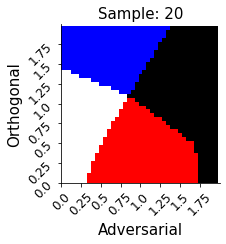

In [405]:
plot_church_window(failed_model, good_samples[i], failed_samples[i],'Sample: %s'%(i+1))

In [395]:
# custom_cmap = colors.ListedColormap(['white','red','green'])
# plt.imshow(ttt,cmap=custom_cmap,origin='lower')

<Figure size 432x288 with 0 Axes>

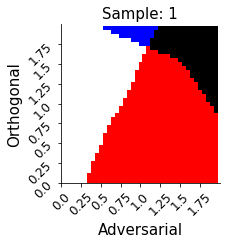

<Figure size 432x288 with 0 Axes>

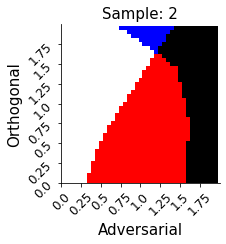

<Figure size 432x288 with 0 Axes>

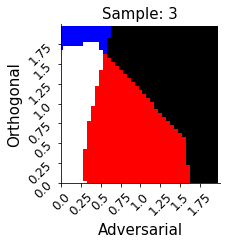

<Figure size 432x288 with 0 Axes>

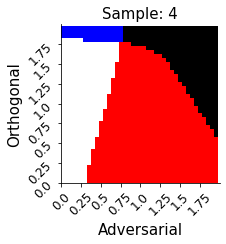

<Figure size 432x288 with 0 Axes>

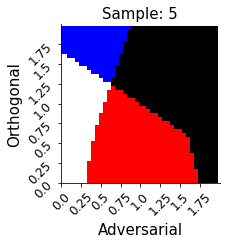

<Figure size 432x288 with 0 Axes>

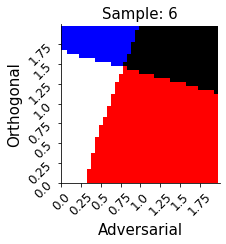

<Figure size 432x288 with 0 Axes>

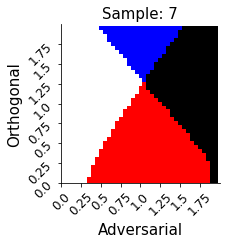

<Figure size 432x288 with 0 Axes>

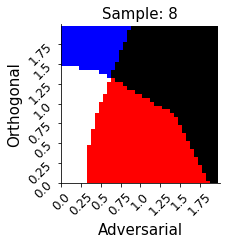

<Figure size 432x288 with 0 Axes>

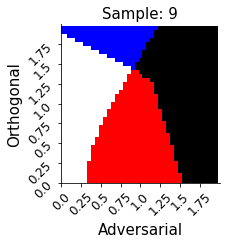

<Figure size 432x288 with 0 Axes>

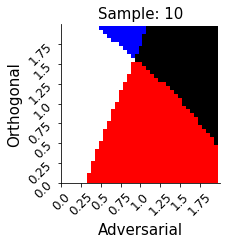

<Figure size 432x288 with 0 Axes>

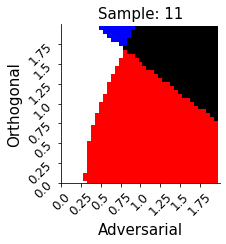

<Figure size 432x288 with 0 Axes>

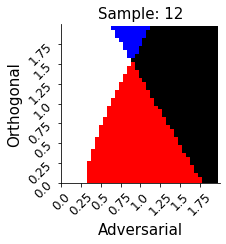

<Figure size 432x288 with 0 Axes>

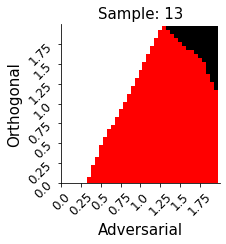

<Figure size 432x288 with 0 Axes>

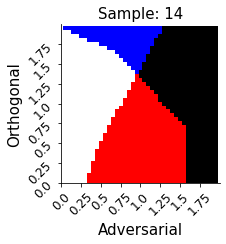

<Figure size 432x288 with 0 Axes>

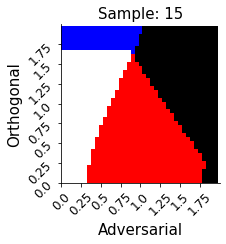

In [406]:
for i in range(5,20):
    plot_church_window(failed_model, good_samples[i], failed_samples[i],'Sample: %s'%(i-4),'sample_%s_with_ood_classified.pdf'%(i+1))

In [281]:
# batch_plot_church_window(failed_model, good_samples, failed_samples,binary = True)

In [247]:

# plt.imshow(ttt[0],cmap=custom_cmap)

In [177]:
# batch_plot_church_window(failed_model, good_samples, failed_samples,binary = False)

# Creating Directions:  Orthogonal, Random, Adv and Start

In [42]:
orthogonal_vectors = torch.zeros((adversarial_vectors.shape))
for i in range(len(adversarial_vectors)):
    adv_vec = adversarial_vectors[i]
    orth_vec = perpendicular_vector(adv_vec)
    orthogonal_vectors[i] = orth_vec

In [43]:
orthogonal_samples = good_samples + orthogonal_vectors

In [44]:
maxes = torch.max(good_samples,dim=0).values
mins = torch.min(good_samples,dim=0).values

In [46]:
random_samples = torch.zeros((good_samples.shape))

for j in range(len(good_samples)):
    random_sample = torch.zeros((good_samples.shape[1]))
    for i in range(len(maxes)):
        r1 = maxes[i]
        r2 = mins[i]
        random_sample[i] = (r1 - r2) * torch.rand(1) + r2
    random_samples[j] = random_sample

# Overlapping Directions: Adv and start

#### Bad samples

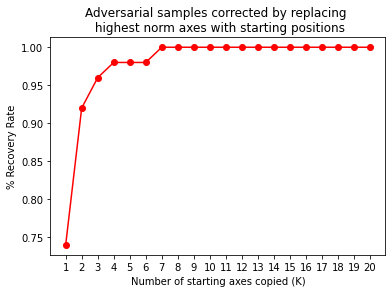

In [83]:
recovery_rates = {}
for K in range(1,21):
    failed_samples_copy = failed_samples.clone()
    top_positions = torch.sort(failed_samples,dim=1).indices[:,-K:]
    for i in range(len(failed_samples_copy)):
        failed_samples_copy[i][top_positions[i]] = good_samples[i][top_positions[i]]

    remaining_errors = torch.sum(predict(failed_model, failed_samples_copy))
    recovery_rate = (len(failed_samples_copy) - remaining_errors)/len(failed_samples_copy)
    recovery_rates[K] = recovery_rate

plt.plot(recovery_rates.values(), marker='o', color='red')
plt.title('Adversarial samples corrected by replacing \n highest norm axes with starting positions')
plt.xticks(range(len(recovery_rates)), labels = recovery_rates.keys())
plt.xlabel('Number of starting axes copied (K)')
plt.ylabel('% Recovery Rate')
plt.show()

#### Good samples

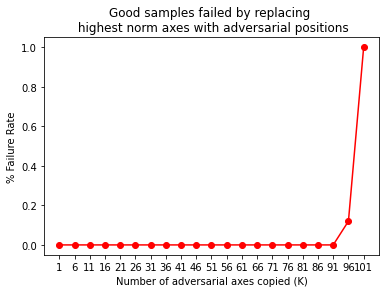

In [84]:
failure_rates = {}
for K in range(1,105,5):
    good_samples_copy = good_samples.clone()
    top_positions = torch.sort(good_samples,dim=1).indices[:,-K:]
    for i in range(len(failed_samples_copy)):
        good_samples_copy[i][top_positions[i]] = failed_samples[i][top_positions[i]]

    new_errors = torch.sum(predict(failed_model, good_samples_copy))
    failure_rate = (new_errors)/len(good_samples_copy)
    failure_rates[K] = failure_rate

plt.plot(failure_rates.values(), marker='o', color='red')
plt.title('Good samples failed by replacing \n highest norm axes with adversarial positions')
plt.xticks(range(len(failure_rates)), labels = failure_rates.keys())
plt.xlabel('Number of adversarial axes copied (K)')
plt.ylabel('% Failure Rate')
plt.show()

# Overlapping Directions: Adv,start and Orthogonal

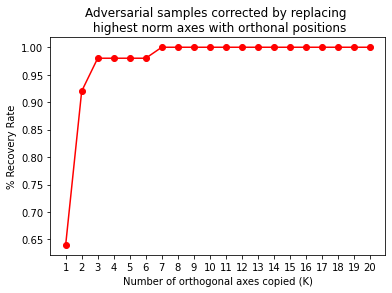

In [85]:
recovery_rates = {}
for K in range(1,21):
    failed_samples_copy = failed_samples.clone()
    top_positions = torch.sort(failed_samples,dim=1).indices[:,-K:]
    for i in range(len(failed_samples_copy)):
        failed_samples_copy[i][top_positions[i]] = orthogonal_samples[i][top_positions[i]]

    remaining_errors = torch.sum(predict(failed_model, failed_samples_copy))
    recovery_rate = (len(failed_samples_copy) - remaining_errors)/len(failed_samples_copy)
    recovery_rates[K] = recovery_rate

plt.plot(recovery_rates.values(), marker='o', color='red')
plt.title('Adversarial samples corrected by replacing \n highest norm axes with orthonal positions')
plt.xticks(range(len(recovery_rates)), labels = recovery_rates.keys())
plt.xlabel('Number of orthogonal axes copied (K)')
plt.ylabel('% Recovery Rate')
plt.show()

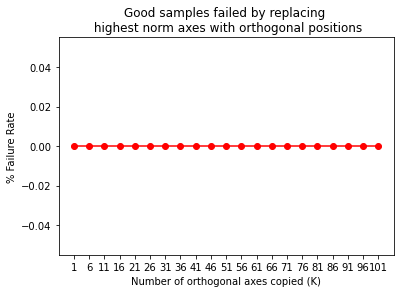

In [86]:
failure_rates = {}
for K in range(1,105,5):
    good_samples_copy = good_samples.clone()
    top_positions = torch.sort(good_samples,dim=1).indices[:,-K:]
    for i in range(len(failed_samples_copy)):
        good_samples_copy[i][top_positions[i]] = orthogonal_samples[i][top_positions[i]]

    new_errors = torch.sum(predict(failed_model, good_samples_copy))
    failure_rate = (new_errors)/len(good_samples_copy)
    failure_rates[K] = failure_rate

plt.plot(failure_rates.values(), marker='o', color='red')
plt.title('Good samples failed by replacing \n highest norm axes with orthogonal positions')
plt.xticks(range(len(failure_rates)), labels = failure_rates.keys())
plt.xlabel('Number of orthogonal axes copied (K)')
plt.ylabel('% Failure Rate')
plt.show()

# Overlapping Directions: Adv, start and Random Directions

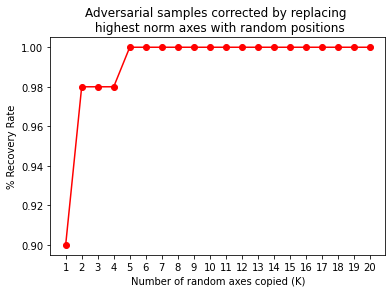

In [87]:
recovery_rates = {}
for K in range(1,21):
    failed_samples_copy = failed_samples.clone()
    top_positions = torch.sort(failed_samples,dim=1).indices[:,-K:]
    for i in range(len(failed_samples_copy)):
        failed_samples_copy[i][top_positions[i]] = random_samples[i][top_positions[i]]

    remaining_errors = torch.sum(predict(failed_model, failed_samples_copy))
    recovery_rate = (len(failed_samples_copy) - remaining_errors)/len(failed_samples_copy)
    recovery_rates[K] = recovery_rate

plt.plot(recovery_rates.values(), marker='o', color='red')
plt.title('Adversarial samples corrected by replacing \n highest norm axes with random positions')
plt.xticks(range(len(recovery_rates)), labels = recovery_rates.keys())
plt.xlabel('Number of random axes copied (K)')
plt.ylabel('% Recovery Rate')
plt.show()

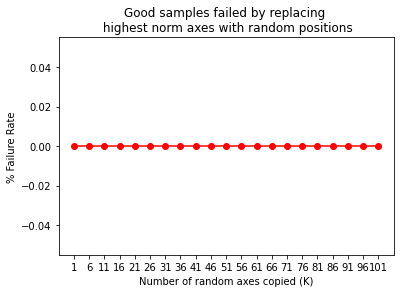

In [88]:
failure_rates = {}
for K in range(1,105,5):
    good_samples_copy = good_samples.clone()
    top_positions = torch.sort(good_samples,dim=1).indices[:,-K:]
    for i in range(len(failed_samples_copy)):
        good_samples_copy[i][top_positions[i]] = random_samples[i][top_positions[i]]

    new_errors = torch.sum(predict(failed_model, good_samples_copy))
    failure_rate = (new_errors)/len(good_samples_copy)
    failure_rates[K] = failure_rate

plt.plot(failure_rates.values(), marker='o', color='red')
plt.title('Good samples failed by replacing \n highest norm axes with random positions')
plt.xticks(range(len(failure_rates)), labels = failure_rates.keys())
plt.xlabel('Number of random axes copied (K)')
plt.ylabel('% Failure Rate')
plt.show()